In [1]:
import os
import random
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
from tqdm import tqdm as tq

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import AutoModel, AutoTokenizer



# 임시 토크나이저
from konlpy.tag import Okt

## check train data

In [2]:
folder = os.getcwd() + '\\open'
train = os.listdir(folder)[2]
test  = os.listdir(folder)[1]
submit = os.listdir(folder)[0]

train = pd.read_csv(folder + '/' + train)
test = pd.read_csv(folder + '/' + test)
submit = pd.read_csv(folder + '/' + submit)
train.head(5)

,ID,label
0,TEST_0000,추론형-긍정-현재-확실
1,TEST_0001,추론형-긍정-현재-확실
2,TEST_0002,추론형-긍정-현재-확실
3,TEST_0003,추론형-긍정-현재-확실
4,TEST_0004,추론형-긍정-현재-확실


In [3]:
print(f"1. num train : {len(train)}\n")
print(f"2. null train check : \n{train.isnull().sum()}\n")
print(f"3. unique labels : \n{train.유형.unique()}\n\
{[len(train[train['유형']==train.유형.unique()[idx]]) for idx in range(len(train.유형.unique()))]}\n\
{train.극성.unique()}\n\
{[len(train[train['극성']==train.극성.unique()[idx]]) for idx in range(len(train.극성.unique()))]}\n\
{train.시제.unique()}\n\
{[len(train[train['시제']==train.시제.unique()[idx]]) for idx in range(len(train.시제.unique()))]}\n\
{train.확실성.unique()}\n\
{[len(train[train['확실성']==train.확실성.unique()[idx]]) for idx in range(len(train.확실성.unique()))]}\n"
)

1. num train : 7090

2. null train check : 
ID       0
label    0
dtype: int64



AttributeError: 'DataFrame' object has no attribute '유형'

## train data 둘러보기

In [4]:
texts = train.문장.tolist()
len(texts)

16541

100%|████████████████████████████████████████████████████████████████████████| 16541/16541 [00:00<00:00, 688321.44it/s]


<AxesSubplot:>

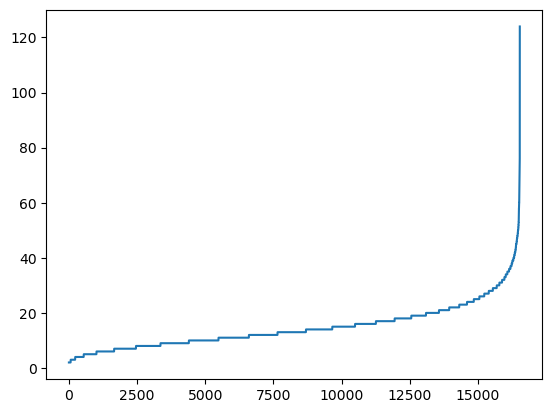

In [13]:
lengths = []
for text in tq(texts):
    lengths.append(len(text.split(' ')))
lengths = pd.DataFrame(sorted(lengths))    
lengths[0].plot()

In [21]:
lengths[lengths[0]>=80]

,0
16539,94
16540,124


[8,
 22,
 12,
 18,
 11,
 14,
 11,
 18,
 10,
 11,
 16,
 9,
 14,
 27,
 16,
 13,
 12,
 8,
 8,
 30,
 14,
 16,
 23,
 10,
 45,
 26,
 17,
 10,
 15,
 8,
 4,
 14,
 13,
 14,
 11,
 17,
 28,
 31,
 5,
 11,
 14,
 4,
 14,
 21,
 14,
 23,
 15,
 20,
 14,
 29,
 11,
 8,
 7,
 25,
 8,
 9,
 17,
 13,
 17,
 6,
 10,
 6,
 8,
 8,
 15,
 21,
 28,
 8,
 23,
 21,
 16,
 7,
 15,
 32,
 11,
 14,
 10,
 10,
 9,
 16,
 12,
 5,
 20,
 24,
 10,
 15,
 16,
 9,
 5,
 34,
 5,
 7,
 12,
 12,
 11,
 10,
 11,
 8,
 10,
 13,
 15,
 34,
 12,
 15,
 11,
 33,
 3,
 14,
 12,
 11,
 10,
 17,
 11,
 11,
 17,
 10,
 6,
 7,
 12,
 20,
 11,
 7,
 12,
 24,
 30,
 8,
 15,
 14,
 9,
 2,
 18,
 14,
 28,
 22,
 40,
 15,
 12,
 7,
 14,
 10,
 12,
 13,
 14,
 5,
 5,
 9,
 19,
 9,
 16,
 10,
 13,
 5,
 14,
 7,
 10,
 14,
 12,
 33,
 17,
 7,
 23,
 4,
 12,
 13,
 8,
 15,
 15,
 5,
 37,
 25,
 12,
 9,
 15,
 17,
 10,
 30,
 10,
 12,
 20,
 41,
 6,
 22,
 19,
 5,
 18,
 9,
 21,
 24,
 10,
 16,
 37,
 12,
 13,
 12,
 15,
 11,
 9,
 38,
 9,
 12,
 10,
 10,
 11,
 7,
 6,
 23,
 7,
 14,
 18,
 22,
 1

In [ ]:
train[train['유형']=='대화형']['문장'].tolist()[74]

In [ ]:
train[train['유형']=='사실형']['문장'].tolist()[500]

In [ ]:
train[train['유형']=='예측형'].iloc[76]

- 예측형  
  - 전망, 예보, 예측, 예정, 예상, 계획, ㄹ-것이다, ㄹ-것으로, -겠다, 가능성, 보인다
  
- 대화형  
  - 니다, -까, -죠, -요, -인가, -더라, -하라

## find frequent words

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")
noun_ext = Okt()

In [ ]:
def wordcounter(data:pd.Series, mode='noun', threshold=30, visible_tqdm = True):
    dic = dict()
    noun_ext = Okt()

    if mode == 'noun':
        func = noun_ext.nouns
    elif mode == 'pos':
        func = noun_ext.pos
    else:
        func = noun_ext.morphs
    
    if visible_tqdm is not None:
        iterator = tq(enumerate(data), total=len(data))
    else:
        iterator = enumerate(data)
    

    for idx, text in iterator:
        nouns = func(text)

        for word in nouns:
            if len(word) <= 1 :
                continue 
            if word in dic:
                dic[word] += 1
            else:
                dic[word] = 1 

                    
    freq_all = sorted(dic.items(), key = lambda item: item[1], reverse = True)                
    freq = []
    
    # threshold 이하는 다 쳐내
    for item in freq_all:
        if item[1] < threshold:
            continue
        freq.append(item)
    
    freq = freq[:50]
    
    return freq

### frequent words of each "type" of text

##### (1) 사실형

In [ ]:
사실형 = train[train['유형']=='사실형']['문장'].tolist()
사실형 = wordcounter(사실형, mode=None, visible_tqdm=True)
사실형

##### (2) 추론형 

In [ ]:
추론형 = train[train['유형']=='추론형']['문장'].tolist()
추론형 = wordcounter(추론형, True)
추론형

##### (3) 예측형

In [ ]:
예측형 = train[train['유형']=='예측형']['문장'].tolist()
예측형 = wordcounter(예측형, True)
예측형

##### (4) 대화형

In [ ]:
대화형 = train[train['유형']=='대화형']['문장'].tolist()
대화형 = wordcounter(대화형, True)
대화형

### frequent words of each "polarity" of text

##### (1) 긍정

In [ ]:
긍정 = train[train['극성']=='긍정']['문장'].tolist()
긍정 = wordcounter(긍정, mode=None, visible_tqdm=True)
긍정

##### (2) 부정

In [ ]:
부정 = train[train['극성']=='부정']['문장'].tolist()
부정 = wordcounter(부정, mode=None, visible_tqdm=True)
부정


##### (3) 미정


In [ ]:
미정 = train[train['극성']=='미정']['문장'].tolist()
미정 = wordcounter(미정, mode=None, visible_tqdm=True)
미정


### frequent words of each "tense" of text

In [ ]:
현재 = train[train['시제']=='현재']['문장'].tolist()
현재 = wordcounter(현재, mode=None, visible_tqdm=True)
현재

In [ ]:
과거 = train[train['시제']=='과거']['문장'].tolist()
과거 = wordcounter(과거, mode=None, visible_tqdm=True)
과거

In [ ]:
미래 = train[train['시제']=='미래']['문장'].tolist()
미래 = wordcounter(미래, mode=None, visible_tqdm=True)
미래

### check test data
- weighted F1 score  
- 

In [ ]:
test.head(5)

### check submit data

In [ ]:
submit.head(5)

### pretrained model  
- 논문으로 공개된 사전 학습 모델(Pre-trained Model) 사용 가능  
- KLUE roberta-large

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, max_len, plm="klue/roberta-large", infer=False):
        self.text      = data['문장'].tolist()
        self.tokenizer = AutoTokenizer.from_pretrained(plm)
        self.max_len   = max_len
        self.infer     = infer
        
        if self.infer is not None:
            type1 = data['유형']=='사실형'
            type2 = data['유형']=='추론형'
            type3 = data['유형']=='예측형'
            type4 = data['유형']=='대화형'
            
            sent1 = data['극성']=='긍정'
            sent2 = data['극성']=='부정'
            sent3 = data['극성']=='미정'
            
            tense1 = data['시제']=='현재'
            tense2 = data['시제']=='과거'
            tense3 = data['시제']=='미래'
            
            certainty1 = data['확실성']=='확실'
            certainty2 = data['확실성']=='불확실'
            
            self.y1 = np.where(type1, 0, 
                      np.where(type2, 1, 
                      np.where(type3, 2, 3))).tolist()
            self.y2 = np.where(sent1, 0,
                      np.where(sent2, 1, 2)).tolist()
            self.y3 = np.where(tense1, 0, 
                      np.where(tense2, 1, 2)).tolist()
            self.y4 = np.where(certainty1, 0, 1).tolist()
                        
            
    def __len__(self):
        return len(self.text)
    
    
    def __getitem__(self, idx):
        text = self.text[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding = 'max_length',
            truncation = True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        x_ids, x_attn = [encoding['input_ids'].flatten(), encoding['attention_mask'].flatten()]
        if self.infer is not None:
            y1 = self.y1[idx]
            y2 = self.y2[idx]
            y3 = self.y3[idx]
            y4 = self.y4[idx]
            
            ys = torch.tensor([y1,y2,y3,y4]) 
            return x_ids, x_attn, ys        
        else:
            return x_ids, x_attn
            
def get_dataloader(data, batch_size, max_len=256, plm="klue/roberta-large", infer=False, shuffle=True):
    return DataLoader(
        dataset=CustomDataset(data=data, max_len=max_len, plm=plm, infer=infer),
        batch_size=batch_size,
        shuffle=shuffle
    )

### data loader

In [12]:
class Classifier(torch.nn.Module):
    def __init__(self, plm = "klue/roberta-large"):
        super().__init__()
        self.activate = torch.nn.SiLU()
        self.dropout = torch.nn.Dropout(p=0.1)
        self.feature_extractor = AutoModel.from_pretrained(plm)
        self.feature_extractor.eval() # freeze FE 
    
        self.type_linear      = self.get_cls()
        self.polarity_linear  = self.get_cls()
        self.tense_linear     = self.get_cls()
        self.certainty_linear = self.get_cls()
            
    def forward(self, x_ids, x_attn):  
        
        x = self.feature_extractor(input_ids=x_ids, attention_mask=x_attn).to_tuple()[0] [:, 0, :] # cls token
                                                                                    # hidden states:0 / last hidden state:1
        y1 = self.type_linear(x)
        y2 = self.polarity_linear(x)
        y3 = self.tense_linear(x)
        y4 = self.certainty_linear(x)
    
        return (y1,y2,y3,y4)

    def get_cls(self):
        return torch.nn.Sequential(
            torch.nn.Linear(1024, 768),
            torch.nn.LayerNorm(768),
            torch.nn.Dropout(p=0.1),
            self.activate,
            torch.nn.Linear(768, 256),
            torch.nn.LayerNorm(256),
            torch.nn.Dropout(p=0.1),
            self.activate,
            torch.nn.Linear(256, 1)
        )  

In [13]:
CFG = {
    'EPOCHS':10,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':256,
    'SEED':41
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [14]:
train_loader = get_dataloader(
    data=train,
    batch_size=CFG['BATCH_SIZE']
)

model = Classifier()
optimizer = torch.optim.Adam(model.parameters())

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

In [17]:
criterions = [torch.nn.CrossEntropyLoss() for _ in range(4)]

In [18]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

model = model.to(device)
criterions = [torch.nn.CrossEntropyLoss().to(device) for _ in range(4)]

for epoch in range(1, CFG['EPOCHS']+1):
    model.train()
    train_loss=[]
    for x_ids, x_attn, y in tq(train_loader):
        x_ids, x_attn, y = x_ids.to(device), x_attn.to(device), y.to(device)
        
        optimizer.zero_grad()
        yhat0, yhat1, yhat2, yhat3 = model(x_ids, x_attn)
        
        loss1 = 0.25*criterions[0](yhat0, y[0])
        loss2 = 0.25*criterions[1](yhat1, y[1])
        loss3 = 0.25*criterions[2](yhat2, y[2])
        loss4 = 0.25*criterions[3](yhat3, y[3])
        
        loss = loss1+loss2+loss3+loss4
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        print(loss.item())

  0%|                                                                                           | 0/65 [00:49<?, ?it/s]


KeyboardInterrupt: 